# Your name:
Sameer Khurana (skhurana)

# Part 3: ImageNet: AlexNet

This notebook implements the AlexNet network for the 1000-class classification task (Task 1) from the Large Scale Visual Recognition Challenge 2012 ([ILSVRC2012](http://www.image-net.org/challenges/LSVRC/2012/)). This implementation is adapted from [here](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py).

In [1]:
# some basic imports and setups
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline
import urllib
from PIL import Image
from torchvision import transforms

## Set up the network

This model was inspired by AlexNet (though it doesn't include local response normalization as in the original 2012 paper). Reference: https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py

In [10]:
from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = ['AlexNet', 'alexnet']

model_url = 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'

# we define the network here
class AlexNet_custom(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet_custom, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6)) # in case input image is larger
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        print(x.shape)
        x = self.avgpool(x)
        print(x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)
        print(x.shape)
        x = self.classifier(x)
        print(x.shape)
        return x

# we load pretrained weights
def alexnet_custom(pretrained=True, progress=True, **kwargs):
    '''AlexNet model architecture from the
    "One weird trick..." <https://arxiv.org/abs/1404.5997> paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    '''
    model = AlexNet_custom(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_url, progress=progress)
        model.load_state_dict(state_dict)
    return model

net = alexnet_custom()

## Load sample test images

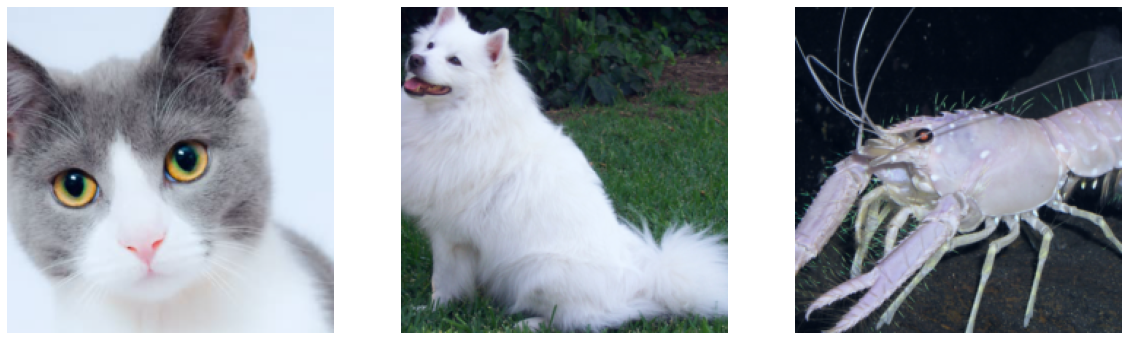

In [3]:
# we download example images

urls = ["https://s3.amazonaws.com/mlpipes/pytorch-quick-start/cat.jpg",\
        "https://github.com/pytorch/hub/raw/master/images/dog.jpg",\
        "https://upload.wikimedia.org/wikipedia/commons/c/c2/Hawaiian_Sea_Lobster.JPG"]
filenames = ["cat.jpg","dog.jpg","Hawaiian_Sea_Lobster.JPG"]

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# we load images into torch tensors, then display them (where pyplot requires the images to be transposed)
input_tensors = torch.zeros((len(urls),3,224,224))
fig = plt.figure(figsize=(20,6))
for i in range(len(urls)):
    url, filename = (urls[i], filenames[i])
    urllib.request.urlretrieve(url, filename)
    input_image = Image.open(filename)

    input_tensor = preprocess(input_image)
    input_tensors[i,:,:,:] = input_tensor

    img = input_tensor.numpy()
    img = img - np.min(img)
    img = img/np.max(img)
    img = img.transpose((1,2,0))
    fig.add_subplot(1,len(urls),i+1)
    plt.imshow(img)
    plt.axis('off')

## Classify the sample test images

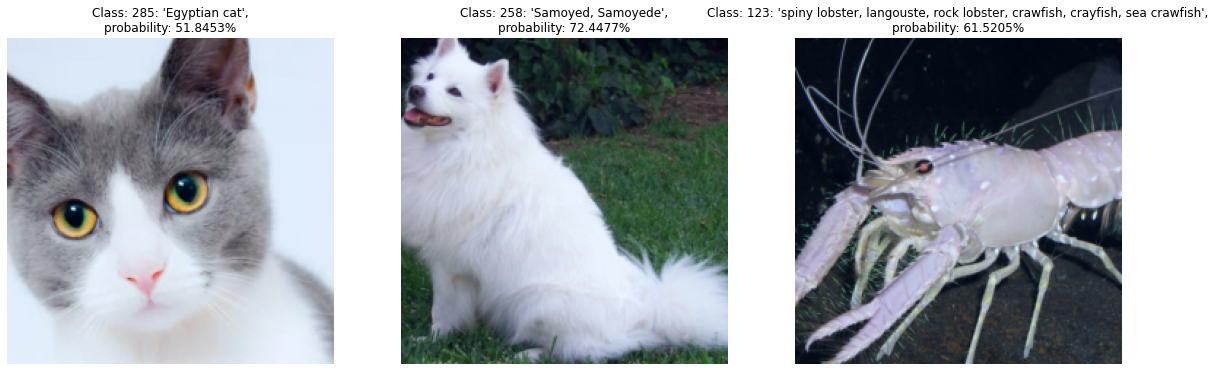

In [4]:
net.eval()
with torch.no_grad():
    out = net(input_tensors)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
# The output has unnormalized scores. To get probabilities, we run a softmax on it.

with open('imagenet_classes_init.txt') as f:
    classes = [line.strip() for line in f.readlines()]

_, index = torch.max(out, 1)

percentage = torch.nn.functional.softmax(out, dim=1)[1] * 100

fig = plt.figure(figsize=(20,6))
# Loop over all images
for i in range(len(urls)):
    # Plot image with class name and prob in the title
    percentage = torch.nn.functional.softmax(out, dim=1)[i] * 100
    
    img = input_tensors[i].numpy()
    img = img - np.min(img)
    img = img/np.max(img)
    img = img.transpose((1,2,0))
    fig.add_subplot(1,len(urls),i+1)
    plt.imshow(img)
    plt.title("Class: " + classes[index[i]] + "\nprobability: %.4f%%" % percentage[index[i]].item())
    plt.axis('off')

### Question 13.

Repeat the calculations from questions 1-4 for __ONLY__ the convolutional, pool and fully-connected layers in the modified AlexNet implemented above.

fc:
`(num_output_nodes, num_input_nodes)`

pool:
`(x_window, y_window, x_stride, y_stride)`

conv:
`(width, height, channels, filter_count, stride_x, stride_y, padding)`

(Note that the convolutional layer parameters are a bit different now.)

The fully-connected layers are very similar to the ones you have already seen. This time, *do not* include ReLU or dropout in the number of layers or layer type list. You can also ignore AdaptiveAvgPool2d.

In [12]:
print(input_tensors.shape)

torch.Size([3, 3, 224, 224])


In [20]:
# Edit these variables to the correct values

num_layers = 11
layer_type = ['conv', 'pool', 'conv', 'pool', 'conv', 'conv', 'conv', 'pool', 'fc', 'fc', 'fc']

network_input_sz = (3, 224, 224, 3)

layer_input_sz = [
    (3, 224, 224, 3),
    (3, 55, 55, 64),
    (3, 27, 27, 64),
    (3, 27, 27, 192),
    (3, 13, 13, 192),
    (3, 13, 13, 384),
    (3, 13, 13, 256),
    (3, 13, 13, 256),
    (3, 6, 6, 256),
    (3, 4096),
    (3, 4096)
]

layer_param = [
    (11,11,3,64,4,4,2),
    (3,3,2,2),
    (5,5,64,192,1,1,2),
    (3,3,2,2),
    (3,3,192,384,1,1,1),
    (3,3,384,256,1,1,1),
    (3,3,256,256,1,1,1),
    (3,3,2,2),
    (4096, 9216),
    (4096, 4096),
    (1000, 4096)
]

In [39]:
def get_output_size(input_sz, layer_type, layer_param):
    batch_size = input_sz[0]
    if len(input_sz) == 4:
        width_in = input_sz[1]
        height_in = input_sz[2]
        channels = input_sz[3]
    if layer_type == 'conv':
        # Your code here
        weight_width, weight_height, channels, filter_count, stride_x, stride_y, padding = layer_param
        height = 1.+((height_in + 2*padding - (weight_height-1)-1) / stride_y)
        height = math.floor(height)
        width = 1.+((width_in + 2*padding - (weight_width-1)-1) / stride_x)
        width = math.floor(width)
        # Return format: (batch_size, width, height, channels)
        return (batch_size, width, height, filter_count)
    elif layer_type == 'pool':
        # Your code here
        padding = 0
        (x_window, y_window, x_stride, y_stride) = layer_param
        height = 1.+((height_in + 2*padding - (y_window-1)-1) / y_stride)
        height = math.floor(height)
        width = 1.+((width_in + 2*padding - (x_window-1)-1) / x_stride)
        width = math.floor(width)
        # Return format: (batch_size, width, height, channels)
        return (batch_size, width, height, channels)
    elif layer_type == 'fc':
        # Your code here
        (num_output_nodes, num_input_nodes) = layer_param
        # Return format: (batch_size, num_outputs)
        return (batch_size, num_output_nodes)
    

def num_params(layer_type, layer_param):
    if layer_type == 'conv':
        # Your code here
        weight_width, weight_height, channels, filter_count, stride_x, stride_y, padding = layer_param
        # +1 for bias
        total_params = ((weight_width * weight_height * channels)+1)*filter_count
        # Return format: (number_of_params)
        return total_params
    elif layer_type == 'pool':
        # Your code here
        total_params = 0
        # Return format: (number_of_params)
        return total_params
    elif layer_type == 'fc':
        # Your code here
        (num_output_nodes, num_input_nodes) = layer_param
        # +num_output_nodes for bias
        total_params = (num_output_nodes * num_input_nodes) + num_output_nodes
        # Return format: (number_of_params)
        return total_params


def param_memory_size(layer_type, layer_param):
    # Your code here
    params = num_params(layer_type, layer_param)
    bit_storage = params * 32.
    mem = bit_storage * 0.125
    # Return format: (mem_size_for_params)
    return mem

def num_mult(input_sz, layer_type, layer_param):
    if layer_type == 'conv':
        # Your code here
        weight_width, weight_height, channels, filter_count, stride_x, stride_y, padding = layer_param
        (batch_size, width_out, height_out, channels_out) = get_output_size(input_sz, layer_type, layer_param)
        num_mult = (weight_width * weight_height * channels) * width_out * height_out * channels_out * batch_size
        # Return format: (number_of_mult)
        return num_mult
    elif layer_type == 'pool':
        # Your code here
        # Return format: (number_of_mult)
        return 0
    elif layer_type == 'fc':
        # Your code here
        batch_size = input_sz[0]
        (num_output_nodes, num_input_nodes) = layer_param
        num_mult = batch_size * num_output_nodes * num_input_nodes
        # Return format: (number_of_mult)
        return num_mult


layer_output_sz = []
layer_params_mem = []
layer_mult_count = []

for n in range(num_layers):
    layer_output_sz.append(get_output_size(layer_input_sz[n], layer_type[n], layer_param[n]))
    layer_params_mem.append(param_memory_size(layer_type[n], layer_param[n]))
    layer_mult_count.append(num_mult(layer_input_sz[n], layer_type[n], layer_param[n]))

print("Network Summary:")
print("# Type\tInput Size\t\tWeight Param\t\t\t\tOutput Size\t\tWeight Memory\t#mult")
for layer_idx in range(num_layers):
    print("%d %s\t%s\t%s\t%s\t%s\t%s" % (
            (layer_idx+1),
            layer_type[layer_idx], 
            str(layer_input_sz[layer_idx]).ljust(16), 
            str(layer_param[layer_idx]).ljust(32), 
            str(layer_output_sz[layer_idx]).ljust(16), 
            str(layer_params_mem[layer_idx]).ljust(12),
            str(layer_mult_count[layer_idx]).ljust(12)
        ))

Network Summary:
# Type	Input Size		Weight Param				Output Size		Weight Memory	#mult
1 conv	(3, 224, 224, 3)	(11, 11, 3, 64, 4, 4, 2)        	(3, 55, 55, 64) 	93184.0     	210830400   
2 pool	(3, 55, 55, 64) 	(3, 3, 2, 2)                    	(3, 27, 27, 64) 	0.0         	0           
3 conv	(3, 27, 27, 64) 	(5, 5, 64, 192, 1, 1, 2)        	(3, 27, 27, 192)	1229568.0   	671846400   
4 pool	(3, 27, 27, 192)	(3, 3, 2, 2)                    	(3, 13, 13, 192)	0.0         	0           
5 conv	(3, 13, 13, 192)	(3, 3, 192, 384, 1, 1, 1)       	(3, 13, 13, 384)	2655744.0   	336420864   
6 conv	(3, 13, 13, 384)	(3, 3, 384, 256, 1, 1, 1)       	(3, 13, 13, 256)	3539968.0   	448561152   
7 conv	(3, 13, 13, 256)	(3, 3, 256, 256, 1, 1, 1)       	(3, 13, 13, 256)	2360320.0   	299040768   
8 pool	(3, 13, 13, 256)	(3, 3, 2, 2)                    	(3, 6, 6, 256)  	0.0         	0           
9 fc	(3, 6, 6, 256)  	(4096, 9216)                    	(3, 4096)       	151011328.0 	113246208   
10 fc	(3, 4096)  

### Question 14.

Count the number of zero input activations to the convolutional and fully-connected layers for the `dog.jpg` image. Be careful about how you index the layers in this step (check the network definition above).

In [40]:
def get_activations(net, x):
    act = []
    first = True
    for mod in net.children():
        for layer in mod.children():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                act.append(x.detach())
            if isinstance(layer, nn.Linear) and first:
                first = False
                x = x.view(x.size(0), 256 * 6 * 6)
            x = layer(x)
    # your code here to get a list of input activations of the convolutional and fully-connected layers

    return act

act = get_activations(net, input_tensors[1].unsqueeze(0))

In [41]:
print("Layer\tTotal\tZeros\tZero Percentage")
nonzero_sum = 0
tot_sum = 0
for i in range(len(act)):
    act_i = act[i].numpy()
    tot, zeros = act_i.size, np.count_nonzero(act_i==0)
    nonzero_sum += tot-zeros
    tot_sum += tot
    frac = 100.0*zeros/tot
    print("%d\t%d\t%d\t%g" % (i+1, tot, zeros, frac))

Layer	Total	Zeros	Zero Percentage
1	150528	72556	48.201
2	46656	21351	45.7626
3	32448	13894	42.8193
4	64896	52526	80.9387
5	43264	33603	77.6697
6	9216	7877	85.4709
7	4096	3507	85.6201
8	4096	3634	88.7207


### Question 15.

Now, we would like to determine the impact of the zero activations on the number of multiplications. Assuming you do not have to perform multiplications for zero activations, count the number of non-zero multiplications when running inference for the `dog.jpg` image.

__Simplifying Assumptions:__
- You can assume that all the learned layer parameters, i.e. weights, are non-zero
- You can ignore the impact of padding


In [46]:
# Your code here
total_mult = 0
non_zero_mult = 0

idx = 0
for n in range(num_layers):
    all_mults = num_mult(layer_input_sz[n], layer_type[n], layer_param[n])
    if all_mults != 0:
        total_mult += all_mults
        zero_acts = np.count_nonzero(act[idx]==0)
        non_zero_mult += (all_mults-zero_acts)
        idx+=1

frac = 100.0*non_zero_mult/total_mult
# # ----------

print("Total Mul\tNon-Zero Mul\tNon-Zero Percentage")
print("%d\t%d\t%g" % (total_mult, non_zero_mult, frac))

Total Mul	Non-Zero Mul	Non-Zero Percentage
2142565440	2142356492	99.9902


### Question 16.

Similar to the neural network we used for mnist, we will evaluate the inference energy and latency for the alexnet model we examined here. Run the below codes, and report the total energy and cycles required to compute convolutional layers in the alexnet. This part may take more than 1 hour to finish, grab a cup of coffee and check back!

In [42]:
!accelergyTables

In [ ]:
from profiler import Profiler
profiler = Profiler(
    top_dir='workloads',
    sub_dir='alexnet',
    timeloop_dir='simple_weight_stationary',
    model=net,
    input_size=(3, 224, 224),
    batch_size=1,
    convert_fc=True,
    exception_module_names=[]
)

results = profiler.profile()

total_energy = 0
total_cycle = 0

for layer_id, info in results.items():
    print(f"ID: {layer_id} \t Energy: {info['energy']} \t Cycle: {info['cycle']} \t Number of same architecture layers: {info['num']}")
    total_energy += info['energy'] * info['num']
    total_cycle += info['cycle'] * info['num']
    
print(f'\nTotal Energy: {total_energy} pj \nTotal Cycles: {total_cycle}')

converting nn.Conv2d and nn.Linear in alexnet model ...
torch.Size([2, 256, 6, 6])
torch.Size([2, 256, 6, 6])
torch.Size([2, 9216])
torch.Size([2, 1000])
workload file --> /home/workspace/lab1/workloads/alexnet/alexnet_layer1.yaml
workload file --> /home/workspace/lab1/workloads/alexnet/alexnet_layer2.yaml
workload file --> /home/workspace/lab1/workloads/alexnet/alexnet_layer3.yaml
workload file --> /home/workspace/lab1/workloads/alexnet/alexnet_layer4.yaml
workload file --> /home/workspace/lab1/workloads/alexnet/alexnet_layer5.yaml
workload file --> /home/workspace/lab1/workloads/alexnet/alexnet_layer6.yaml
workload file --> /home/workspace/lab1/workloads/alexnet/alexnet_layer7.yaml
workload file --> /home/workspace/lab1/workloads/alexnet/alexnet_layer8.yaml
conversion complete!

running timeloop to get energy and latency...


 12%|█▎        | 1/8 [06:35<46:09, 395.59s/it]

Report the total energy and cycles below:

Energy:


-your answers here-



Cycles:


-your answers here-

